In [ ]:
import ast
import graphviz
import itertools
from functools import partial, reduce
from IPython.display import SVG

def recurse_through_ast(node, handle_ast, handle_terminal, handle_fields, handle_no_fields, omit_docstrings):
    possible_docstring = isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.Module))
    
    node_fields = zip(
        node._fields,
        (getattr(node, attr) for attr in node._fields)
    )
    field_results = []
    for field_name, field_value in node_fields:
        print(field_name, field_value)
        if isinstance(field_value, ast.AST):
            field_results.append(handle_ast(field_value))
        
        elif isinstance(field_value, list):
            if possible_docstring and omit_docstrings and field_name == 'body':
                field_value = _strip_docstring(field_value)
            field_results.extend(
                handle_ast(item)
                if isinstance(item, ast.AST) else
                handle_terminal(item)
                for item in field_value
            )
        
        elif isinstance(field_value, str):
            field_results.append(handle_terminal('"{}"'.format(field_value)))
            
        elif field_value is not None:
            field_results.append(handle_terminal(field_value))

    if not field_results:
        return handle_no_fields(node)

    return handle_fields(node, field_results)

my_settings = dict(
    # Styling options:
    scale=2,
    font='courier',
    shape='none',
    terminal_color='#800040',
    nonterminal_color='#004080',
    # AST display options:
    omit_module=True,
    omit_docstrings=True,
)

def _strip_docstring(body):
    first = body[0]
    if isinstance(first, ast.Expr) and isinstance(first.value, ast.Str):
        return body[1:]
    return body

def _bold(label):
    return '<<B>{}</B>>'.format(label)


def _attach_to_parent(parent, graph, names, label, name=None, **style):
    node_name = next(names) if name is None else name
    node = graph.node(node_name, label=label, **style)
    if parent is not None:
        graph.edge(parent, node_name, sametail='t{}'.format(parent))


def handle_ast(node, parent_node, graph, names, omit_docstrings, terminal_color, nonterminal_color):
    attach_to_parent = partial(
        _attach_to_parent,
        graph=graph,
        names=names,
    )
    node_name = next(names)
    attach_to_parent(
        parent=parent_node,
        label=_bold(node.__class__.__name__),
        name=node_name,
        fontcolor=nonterminal_color,
    )
    recurse_through_ast(
        node, 
        partial(
            handle_ast, 
            parent_node=node_name,
            graph=graph,
            names=names,
            omit_docstrings=omit_docstrings, 
            terminal_color=terminal_color, 
            nonterminal_color=nonterminal_color,
        ), 
        partial(
            handle_terminal, 
            attach_to_parent=partial(
                attach_to_parent, 
                parent=node_name, 
                fontcolor=terminal_color,
            ),
        ), 
        handle_fields, 
        partial(
            handle_no_fields,
            parent_node=node_name,
            graph=graph,
            terminal_color=terminal_color,
            nonterminal_color=nonterminal_color,
        ),
        omit_docstrings,
    )


def handle_terminal(terminal, attach_to_parent):
    attach_to_parent(label=str(terminal))


def handle_fields(*__):
    pass


def handle_no_fields(__, parent_node, graph, terminal_color, nonterminal_color):
    parent_node_beginning = '{} '.format(parent_node)
    parent_node_num = int(parent_node)
    for i, node in enumerate(graph.body[parent_node_num:]):
        if node.strip().startswith(parent_node_beginning):
            break
    else:
        raise KeyError("Could not find parent in graph.")
    replacements = {
        nonterminal_color: terminal_color,
        '<<B>': '',
        '</B>>': '',
    }
    graph.body[i + parent_node_num] = reduce(
        lambda s, replacement: s.replace(*replacement),
        replacements.items(),
        node,
    )
    
def render(node, settings):
    """
    Given an AST node and settings, return a displayable object.
    """
    graph = graphviz.Graph(format='svg')
    names = (str(x) for x in itertools.count())

    handle_ast(
        node,
        parent_node=None,
        graph=graph,
        names=names,
        omit_docstrings=settings['omit_docstrings'],
        terminal_color=settings['terminal_color'],
        nonterminal_color=settings['nonterminal_color'],
    )

    graph.node_attr.update(dict(
        fontname=settings['font'],
        shape=settings['shape'],
    ))

    return SVG(graph.pipe(format='svg'))

def viz_code(code):
    return render(ast.parse(code), my_settings)

: 

In [10]:
my_settings = dict(
    # Styling options:
    scale=2,
    font='courier',
    shape='none',
    terminal_color='#800040',
    nonterminal_color='#004080',
    # AST display options:
    omit_module=True,
    omit_docstrings=False,
)


In [23]:
from io import StringIO
import tokenize

def scan_comments(source):
    """ Scan source code file for relevant comments
    """
    # Find token for comments
    for k,v in tokenize.tok_name.items():
        if v == 'COMMENT':
            comment = k
            break
    comtokens = []
    with StringIO(source) as f:
        tokens = tokenize.generate_tokens(f.readline)
        for token in tokens:
            if token.type != comment:
                continue
            comtokens += [token]
    return comtokens

comtokens = scan_comments(boba_template_code)
print('== Comment after p1l[0]\n\t', comtokens[1])


== Comment after p1l[0]
	 TokenInfo(type=55 (COMMENT), string='# --- (BOBA_CONFIG)', start=(7, 0), end=(7, 19), line='# --- (BOBA_CONFIG)\n')


In [31]:
hi_code = '''
def hello():
    """Return Hi."""
    return 'Hi!' # haah
'''
_strip_docstring(ast.dump(ast.parse(hi_code)))


"Module(body=[FunctionDef(name='hello', args=arguments(args=[], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), body=[Expr(value=Str(s='Return Hi.')), Return(value=Str(s='Hi!'))], decorator_list=[], returns=None)])"

body [<_ast.FunctionDef object at 0x7f8ddbab5c50>]
name hello
args <_ast.arguments object at 0x7f8ddbab5810>
args []
vararg None
kwonlyargs []
kw_defaults []
kwarg None
defaults []
body [<_ast.Expr object at 0x7f8ddbab5b50>, <_ast.Return object at 0x7f8ddbab5150>]
value <_ast.Str object at 0x7f8ddbab5fd0>
s Hi!
decorator_list []
returns None


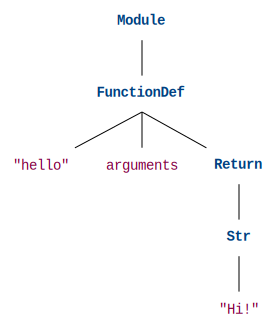

In [32]:
viz_code(hi_code)


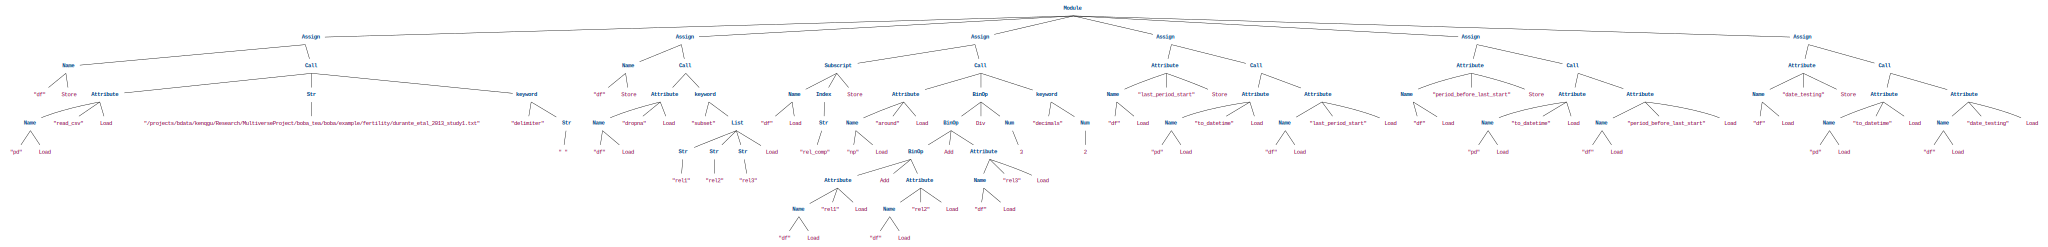

In [13]:
boba_code = """df = pd.read_csv('/projects/bdata/kenqgu/Research/MultiverseProject/boba_tea/boba/example/fertility/durante_etal_2013_study1.txt', delimiter='\t')

# remove NA
df = df.dropna(subset=['rel1', 'rel2', 'rel3'])

# create religiosity score
df['rel_comp'] = np.around((df.rel1 + df.rel2 + df.rel3) / 3, decimals=2)

# next menstrual onset (nmo) assessment
df.last_period_start = pd.to_datetime(df.last_period_start)
df.period_before_last_start = pd.to_datetime(df.period_before_last_start)
df.date_testing = pd.to_datetime(df.date_testing)
"""
viz_code(boba_code)


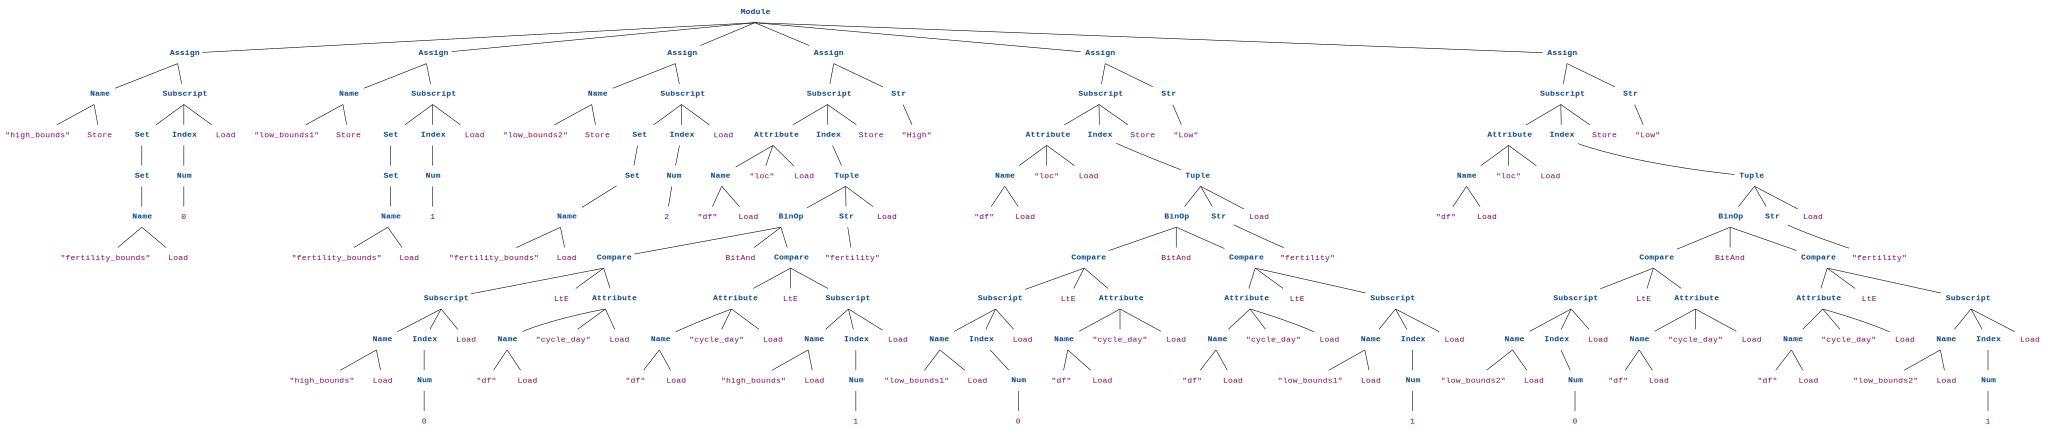

In [14]:
boba_code = """high_bounds = {{fertility_bounds}}[0]
low_bounds1 = {{fertility_bounds}}[1]
low_bounds2 = {{fertility_bounds}}[2]
df.loc[(high_bounds[0] <= df.cycle_day) & (df.cycle_day <= high_bounds[1]),
        'fertility'] = 'High'
df.loc[(low_bounds1[0] <= df.cycle_day) & (df.cycle_day <= low_bounds1[1]),
        'fertility'] = 'Low'
df.loc[(low_bounds2[0] <= df.cycle_day) & (df.cycle_day <= low_bounds2[1]),
        'fertility'] = 'Low'
"""
viz_code(boba_code)


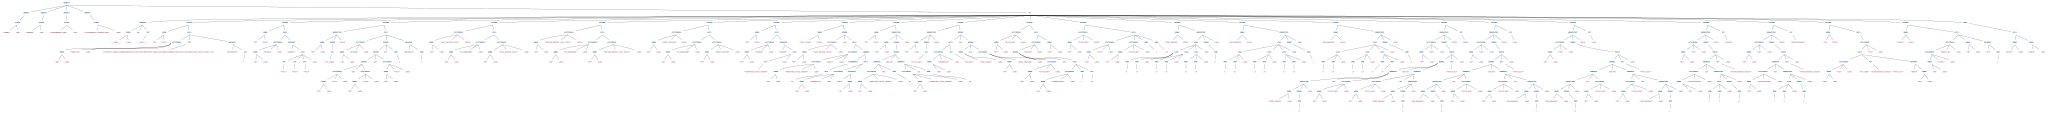

In [15]:
boba_code = """#!/usr/bin/env python3

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

if __name__ == '__main__':
    # read data file
    df = pd.read_csv('/projects/bdata/kenqgu/Research/MultiverseProject/boba_tea/boba/example/fertility/durante_etal_2013_study1.txt', delimiter='\t')

    # remove NA
    df = df.dropna(subset=['rel1', 'rel2', 'rel3'])

    # create religiosity score
    df['rel_comp'] = np.around((df.rel1 + df.rel2 + df.rel3) / 3, decimals=2)

    # next menstrual onset (nmo) assessment
    df.last_period_start = pd.to_datetime(df.last_period_start)
    df.period_before_last_start = pd.to_datetime(df.period_before_last_start)
    df.date_testing = pd.to_datetime(df.date_testing)

    # second nmo option: based on reported cycle length
    df = df.dropna(subset=['reported_cycle_length'])
    next_onset = df.last_period_start + df.reported_cycle_length.apply(
        lambda a: pd.Timedelta(days=a))

    # exclusion based on reported cycle length
    df = df[(df.reported_cycle_length >= 25) & (df.reported_cycle_length <= 35)]

    # compute cycle day
    df['cycle_day'] = pd.Timedelta('28 days') - (next_onset - df.date_testing)
    df.cycle_day = (df.cycle_day / np.timedelta64(1, 'D')).astype(int)
    df.cycle_day = np.clip(df.cycle_day, 1, 28)

    # fertility assessment
    high_bounds = [[6, 14], [17, 27], [17, 27]][0]
    low_bounds1 = [[6, 14], [17, 27], [17, 27]][1]
    low_bounds2 = [[6, 14], [17, 27], [17, 27]][2]
    df.loc[(high_bounds[0] <= df.cycle_day) & (df.cycle_day <= high_bounds[1]),
           'fertility'] = 'High'
    df.loc[(low_bounds1[0] <= df.cycle_day) & (df.cycle_day <= low_bounds1[1]),
           'fertility'] = 'Low'
    df.loc[(low_bounds2[0] <= df.cycle_day) & (df.cycle_day <= low_bounds2[1]),
           'fertility'] = 'Low'

    # relationship status assessment
    # single = response options 1 and 2; relationship = response options 3 and 4
    df.loc[df.relationship <= [1, 2][0],
           'relationship_status'] = 'Single'
    df.loc[df.relationship >= [1, 2][1],
           'relationship_status'] = 'Relationship'

    # perform an ANOVA on the processed data set
    lm = smf.ols('rel_comp ~ relationship_status * fertility', data=df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table)
"""


viz_code(boba_code)

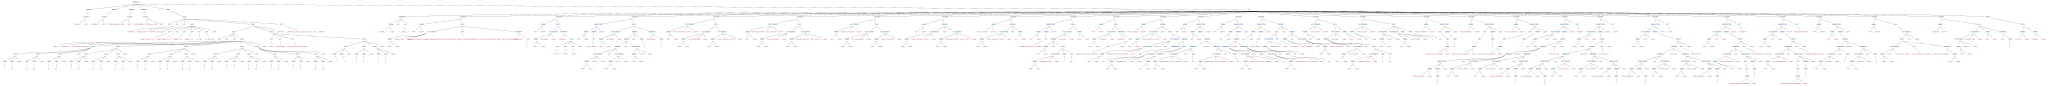

In [16]:
boba_template_code = """#!/usr/bin/env python3

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
# --- (BOBA_CONFIG)
{
  "graph": [
    "NMO1->ECL1->A",
    "NMO2->ECL2->A",
    "NMO1->A",
    "NMO2->A",
    "A->B",
    "A->EC->B"
  ],
  "decisions": [
    {"var": "fertility_bounds", "options": [
      [[7, 14], [17, 25], [17, 25]],
      [[6, 14], [17, 27], [17, 27]],
      [[9, 17], [18, 25], [18, 25]],
      [[8, 14], [1, 7], [15, 28]],
      [[9, 17], [1, 8], [18, 28]]
    ]},
    {"var": "relationship_bounds",
      "options": [[2, 3], [1, 2], [1, 3]]}
  ],
  "before_execute": "cp ../durante_etal_2013_study1.txt ./code/"
}
# --- (END)

if __name__ == '__main__':
    # read data file
    df = pd.read_csv('/projects/bdata/kenqgu/Research/MultiverseProject/boba_tea/boba/example/fertility/durante_etal_2013_study1.txt', delimiter='\t')

    # remove NA
    df = df.dropna(subset=['rel1', 'rel2', 'rel3'])

    # create religiosity score
    df['rel_comp'] = np.around((df.rel1 + df.rel2 + df.rel3) / 3, decimals=2)

    # next menstrual onset (nmo) assessment
    df.last_period_start = pd.to_datetime(df.last_period_start)
    df.period_before_last_start = pd.to_datetime(df.period_before_last_start)
    df.date_testing = pd.to_datetime(df.date_testing)

    # --- (NMO1)
    # first nmo option: based on computed cycle length
    cl = df.last_period_start - df.period_before_last_start
    next_onset = df.last_period_start + cl
    df['computed_cycle_length'] = (cl / np.timedelta64(1, 'D')).astype(int)

    # --- (NMO2)
    # second nmo option: based on reported cycle length
    df = df.dropna(subset=['reported_cycle_length'])
    next_onset = df.last_period_start + df.reported_cycle_length.apply(
        lambda a: pd.Timedelta(days=a))

    # --- (ECL1)
    # exclusion based on computed cycle length
    df = df[(df.computed_cycle_length >= 25) & (df.computed_cycle_length <= 35)]

    # --- (ECL2)
    # exclusion based on reported cycle length
    df = df[(df.reported_cycle_length >= 25) & (df.reported_cycle_length <= 35)]

    # --- (A)
    # compute cycle day
    df['cycle_day'] = pd.Timedelta('28 days') - (next_onset - df.date_testing)
    df.cycle_day = (df.cycle_day / np.timedelta64(1, 'D')).astype(int)
    df.cycle_day = np.clip(df.cycle_day, 1, 28)

    # fertility assessment
    high_bounds = {{fertility_bounds}}[0]
    low_bounds1 = {{fertility_bounds}}[1]
    low_bounds2 = {{fertility_bounds}}[2]
    df.loc[(high_bounds[0] <= df.cycle_day) & (df.cycle_day <= high_bounds[1]),
           'fertility'] = 'High'
    df.loc[(low_bounds1[0] <= df.cycle_day) & (df.cycle_day <= low_bounds1[1]),
           'fertility'] = 'Low'
    df.loc[(low_bounds2[0] <= df.cycle_day) & (df.cycle_day <= low_bounds2[1]),
           'fertility'] = 'Low'

    # relationship status assessment
    # single = response options 1 and 2; relationship = response options 3 and 4
    df.loc[df.relationship <= {{relationship_bounds}}[0],
           'relationship_status'] = 'Single'
    df.loc[df.relationship >= {{relationship_bounds}}[1],
           'relationship_status'] = 'Relationship'

    # --- (EC)
    # exclusion based on certainty ratings
    df = df[(df.sure1 >= 6) & (df.sure2 >= 6)]

    # --- (B)
    # perform an ANOVA on the processed data set
    lm = smf.ols('rel_comp ~ relationship_status * fertility', data=df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table)
"""

viz_code(boba_template_code)